#Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
import os
import random
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc
from sklearn.utils import shuffle

BASE_DIR = '/content/drive/Shareddrives/DeepLearningProject/Coccomini_Gholami_Zara/data/numpy data/'
MODELS_DIR = '/content/drive/Shareddrives/DeepLearningProject/Coccomini_Gholami_Zara/models/BM/'

PUBLIC_TEST_TENSOR = BASE_DIR + 'public_test_tensor.npy'
PUBLIC_TEST_LABELS = BASE_DIR + 'public_test_labels.npy'
PRIVATE_TEST_TENSOR = BASE_DIR + 'private_test_tensor.npy'

TRAIN_LABELS = BASE_DIR + 'train_labels.npy'
TRAIN_TENSOR = BASE_DIR + 'train_tensor.npy'

# training hyperparameters
K_FOLDS = 4
INCEPTION_KFOLD_VALIDATION_EPOCHS = 40
INCEPTION_TRAIN_EPOCHS = 50
RESNET_KFOLD_VALIDATION_EPOCHS = 40
RESNET_TRAIN_EPOCHS = 200
VGG16_KFOLD_VALIDATION_EPOCHS = 40
VGG16_TRAIN_EPOCHS = 50
BATCH_SIZE = 16
VERBOSE = 1
CLASS_WEIGHT = {0: 2.,
                1: 1.}

process_manager = multiprocessing.Manager()

final_models_preds = {}
fine_tuned_models_preds = {}

In [ ]:
raw_train_data = np.load(TRAIN_TENSOR).reshape((5352, 150, 150, 1))
raw_train_labels = np.load(TRAIN_LABELS)
raw_test_data = np.load(PUBLIC_TEST_TENSOR).reshape((672, 150, 150, 1))
raw_test_labels = np.load(PUBLIC_TEST_LABELS)

# 0: baseline; 1-2: masses (b-m); 3-4: calcifications (b-m)

# Convert the dataset into a two-class one with only considering "benign" (0) and "malignant" (1).
def collapse_labels(labels):
  collapsed_labels = np.where((labels % 2) == 0, 1, 0)
  return collapsed_labels

# Datasets without baseline (class 0)
train_data_no_baseline =  raw_train_data[1::2]
train_labels_no_baseline =  raw_train_labels[1::2]
test_data_no_baseline =  raw_test_data[1::2]
test_labels_no_baseline =  raw_test_labels[1::2]

#copy grayscale channel to channel 2 and 3 because pretrained models work with rgb images
train_data_no_baseline_RGB = np.concatenate((train_data_no_baseline[:], train_data_no_baseline[:], train_data_no_baseline[:]), axis=3);
test_data_no_baseline_RGB = np.concatenate((test_data_no_baseline[:], test_data_no_baseline[:], test_data_no_baseline[:]), axis=3);

# Collapse labels in benign and malignant classes
collapsed_train_labels = collapse_labels(train_labels_no_baseline)
collapsed_test_labels = collapse_labels(test_labels_no_baseline)

#prepare data for the k-foldgene
kfold_data, kfold_labels = shuffle(train_data_no_baseline_RGB, collapsed_train_labels)
num_val_samples = len(kfold_data) // K_FOLDS

###Data Visualization

In [ ]:
def show_accuracy_loss_trends(fit_results):
  acc = fit_results['accuracy']
  val_acc = fit_results['val_accuracy']
  loss = fit_results['loss']
  val_loss = fit_results['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.ylim((0, 1))
  plt.plot(epochs, acc, 'g', label='Training acc')
  plt.plot(epochs, val_acc, 'g--', label='Validation acc')
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'r--', label='Validation loss')
  plt.legend()

  plt.show()

In [ ]:
def show_confusion_matrix(confusion_matrix):
  fig, ax = plt.subplots()
  im = ax.imshow(confusion_matrix, cmap="Blues")

  threshold = im.norm(confusion_matrix.max())/2.
  textcolors=("black", "white")

  ax.set_xticks(np.arange(2))
  ax.set_yticks(np.arange(2))
  ax.set_xticklabels(["benign", "malignant"])
  ax.set_yticklabels(["benign", "malignant"])
  
  ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

  for i in range(2):
      for j in range(2):
          text = ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", 
                         fontsize=12, color=textcolors[int(im.norm(confusion_matrix[i, j]) > threshold)])

  fig.tight_layout()
  plt.show()

In [ ]:
def show_roc_curves(models_preds):
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')

  for model, model_preds in models_preds.items():
    fpr,tpr,th = metrics.roc_curve(collapsed_test_labels,model_preds)
    model_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label= model + ' (area = {:.3f})'.format(model_auc))

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

###Data Augmentation

In [ ]:
# data augmentation hyperparameters
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 360
FILL_MODE='nearest'

def get_train_datagen(preprocess):
  from tensorflow import keras
  from keras.preprocessing.image import ImageDataGenerator
  return ImageDataGenerator(
        preprocessing_function=preprocess,
        horizontal_flip = HORIZONTAL_FLIP,
        vertical_flip = VERTICAL_FLIP, 
        rotation_range = ROTATION_RANGE,
        fill_mode=FILL_MODE
      )

def get_validation_datagen(preprocess):
  from tensorflow import keras
  from keras.preprocessing.image import ImageDataGenerator
  return ImageDataGenerator(
        preprocessing_function=preprocess
      )

# InceptionV3



### Model architecture

In [ ]:
def get_inception_model():
  from tensorflow import keras
  from keras import layers
  from keras import models
  from keras.applications import InceptionV3
  InceptionV3_conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
  InceptionV3_conv_base.trainable = False

  inception_model = models.Sequential()
  inception_model.add(InceptionV3_conv_base)
  inception_model.add(layers.Flatten())
  inception_model.add(layers.Dense(256, activation = "sigmoid"))
  inception_model.add(layers.Dense(1, activation = "sigmoid"))

  # ada = keras.optimizers.Adam(learning_rate=0.001)
  # sgd = keras.optimizers.SGD(learning_rate=0.1)
  rms = keras.optimizers.RMSprop(lr=2e-6)
  inception_model.compile(loss="binary_crossentropy", optimizer=rms, metrics=['accuracy'])
  return inception_model

### Training

In [ ]:
def inception_fold_train(fold, fit_results_list, validation_results_list):
  from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess
  if VERBOSE == 1: print("\nFold " + str(fold + 1) + " training")
  kfold_train_data = np.concatenate([kfold_data[:fold * num_val_samples],  kfold_data[(fold + 1) * num_val_samples:]], axis=0)
  kfold_validation_data = kfold_data[fold * num_val_samples: (fold + 1) * num_val_samples]

  kfold_train_labels = np.concatenate([kfold_labels[:fold * num_val_samples],  kfold_labels[(fold+ 1) * num_val_samples:]], axis=0)
  kfold_validation_labels = kfold_labels[fold * num_val_samples: (fold + 1) * num_val_samples]
  
  inception_train_datagen = get_train_datagen(inception_v3_preprocess)
  inception_validation_datagen = get_validation_datagen(inception_v3_preprocess)
  inception_train_datagen.fit(kfold_train_data)
  inception_validation_datagen.fit(kfold_validation_data)
  inception_train_generator = inception_train_datagen.flow(kfold_train_data, kfold_train_labels, batch_size=BATCH_SIZE)
  inception_validation_generator = inception_validation_datagen.flow(kfold_validation_data, kfold_validation_labels, batch_size=BATCH_SIZE)

  model = get_inception_model()
  fit_results = model.fit(
      inception_train_generator,
      epochs=INCEPTION_KFOLD_VALIDATION_EPOCHS,
      steps_per_epoch=int(np.ceil(inception_train_generator.n / float(BATCH_SIZE))),
      validation_data=inception_validation_generator,
      validation_steps=int(np.ceil(inception_validation_generator.n / float(BATCH_SIZE))),
      verbose=VERBOSE
  )

  validation_results = model.evaluate(inception_validation_generator, verbose=VERBOSE)

  
  fit_results_list.append(fit_results.history)
  validation_results_list.append(validation_results[1])


Fold 1 training
Epoch 1/40
126/126 [==============================] - 19s 105ms/step - loss: 0.7254 - accuracy: 0.5009 - val_loss: 0.6631 - val_accuracy: 0.6039
Epoch 2/40
126/126 [==============================] - 11s 88ms/step - loss: 0.6643 - accuracy: 0.5890 - val_loss: 0.6561 - val_accuracy: 0.6129
Epoch 3/40
126/126 [==============================] - 11s 88ms/step - loss: 0.6637 - accuracy: 0.5990 - val_loss: 0.6523 - val_accuracy: 0.5949
Epoch 4/40
126/126 [==============================] - 11s 88ms/step - loss: 0.6435 - accuracy: 0.6123 - val_loss: 0.6471 - val_accuracy: 0.6263
Epoch 5/40
126/126 [==============================] - 11s 86ms/step - loss: 0.6569 - accuracy: 0.5973 - val_loss: 0.6493 - val_accuracy: 0.5934
Epoch 6/40
126/126 [==============================] - 11s 87ms/step - loss: 0.6711 - accuracy: 0.5767 - val_loss: 0.6570 - val_accuracy: 0.6039
Epoch 7/40
126/126 [==============================] - 11s 91ms/step - loss: 0.6512 - accuracy: 0.6095 - val_loss: 0.65

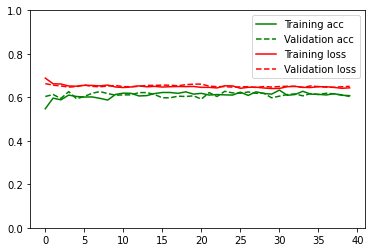

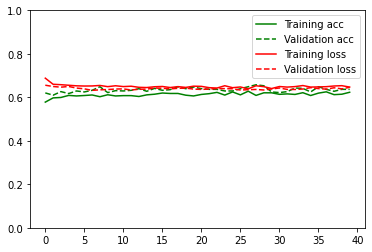

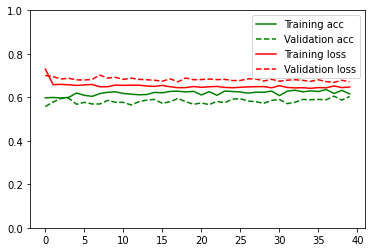

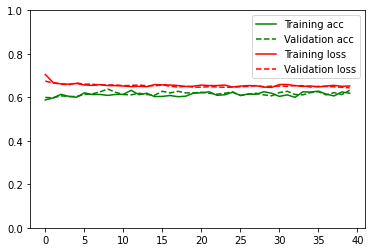


4-fold inception validation accuracy
Mean: 0.6192077845335007	Std: 0.015403172506240412


In [ ]:
fit_results_list = process_manager.list()
validation_results_list = process_manager.list()

#execute each fold in a secondary process to avoid RAM saturation
for fold in range(K_FOLDS):
    p = multiprocessing.Process(target=inception_fold_train, args=(fold, fit_results_list, validation_results_list))
    p.start()
    p.join()

for fit_results in fit_results_list:
  show_accuracy_loss_trends(fit_results)

validation_mean = np.mean(validation_results_list)
validation_std = np.std(validation_results_list)
print("\n" + str(K_FOLDS) + "-fold inception validation accuracy\nMean: " + str(validation_mean) + "\tStd: " + str(validation_std))

###Evaluation

In [ ]:
def inception_test(inception_preds):
  if VERBOSE == 1: print("Testing")
  from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess
  train_data, validation_data, train_labels, validation_labels = train_test_split(
                                                                                  train_data_no_baseline_RGB,
                                                                                  collapsed_train_labels,
                                                                                  train_size=0.8,
                                                                                  random_state=42,
                                                                                  shuffle=True
                                                                                )


  inception_train_datagen = get_train_datagen(inception_v3_preprocess)
  inception_validation_datagen = get_validation_datagen(inception_v3_preprocess)
  inception_train_datagen.fit(train_data)
  inception_validation_datagen.fit(validation_data)
  inception_train_generator = inception_train_datagen.flow(train_data, train_labels, batch_size=BATCH_SIZE)
  inception_validation_generator = inception_validation_datagen.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)


  model = get_inception_model()
  fit_results = model.fit(
      inception_train_generator,
      epochs=INCEPTION_TRAIN_EPOCHS,
      steps_per_epoch=int(np.ceil(inception_train_generator.n / float(BATCH_SIZE))),
      validation_data=inception_validation_generator,
      validation_steps=int(np.ceil(inception_validation_generator.n / float(BATCH_SIZE))),
      verbose=VERBOSE
  )
  
  show_accuracy_loss_trends(fit_results.history)

  preds = model.predict(test_data_no_baseline_RGB)
  for pred in preds:
    inception_preds.append(pred[0])
  
  model.save(os.path.join(MODELS_DIR,'pretrained_inception.h5'))

Testing
87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/50
134/134 [==============================] - 25s 105ms/step - loss: 0.6866 - accuracy: 0.5772 - val_loss: 0.6663 - val_accuracy: 0.5765
Epoch 2/50
134/134 [==============================] - 12s 90ms/step - loss: 0.6564 - accuracy: 0.6102 - val_loss: 0.6543 - val_accuracy: 0.6194
Epoch 3/50
134/134 [==============================] - 12s 89ms/step - loss: 0.6656 - accuracy: 0.5928 - val_loss: 0.6552 - val_accuracy: 0.6119
Epoch 4/50
134/134 [==============================] - 12s 89ms/step - loss: 0.6549 - accuracy: 0.6115 - val_loss: 0.6616 - val_accuracy: 0.6082
Epoch 5/50
134/134 [==============================] - 12s 91ms/step - loss: 0.6494 - accuracy: 0.6189 - val_loss: 0.6539 - val_accuracy: 0.6231
Epoch 6/50
134/134 [==============================] - 12s 89ms/step - loss: 0.6581 - accuracy: 0.6063 - val_loss: 0.6471 - val_accuracy: 0.6287
Epoch 7/50
134/134 [==============================] - 12s 90ms

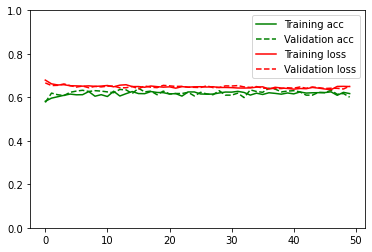

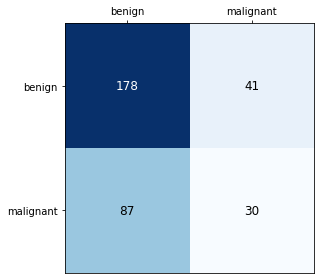


Inception test accuracy: 0.6190476190476191


In [ ]:
preds = process_manager.list()

#execute testing in a secondary process to avoid RAM saturation
p = multiprocessing.Process(target=inception_test, args=(preds, ))
p.start()
p.join()

preds = np.asarray(preds)

show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
print("\nInception test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

final_models_preds.update({"inception": preds})

# ResNet50

### Model architecture

In [ ]:
def get_resnet_model():
  from tensorflow import keras
  from keras import layers
  from keras import models
  from keras.layers import BatchNormalization
  from keras.applications import ResNet50
  ResNet50_conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
  ResNet50_conv_base.trainable = False

  resnet_model = models.Sequential()
  resnet_model.add(ResNet50_conv_base)
  resnet_model.add(layers.Flatten())
  resnet_model.add(BatchNormalization())
  resnet_model.add(layers.Dense(256, activation = "sigmoid"))
  resnet_model.add(layers.Dense(1, activation = "sigmoid"))

  ada = keras.optimizers.Adam(learning_rate=0.001)
  # sgd = keras.optimizers.SGD(learning_rate=0.1)
  #rms = keras.optimizers.RMSprop(lr=2e-6)
  resnet_model.compile(loss="binary_crossentropy", optimizer=ada, metrics=['accuracy'])
  return resnet_model

### Training

In [ ]:
def resnet_fold_train(fold, fit_results_list, validation_results_list):
  from keras.applications.resnet import preprocess_input as resnet_preprocess
  if VERBOSE == 1: print("\nFold " + str(fold + 1) + " training")
  kfold_train_data = np.concatenate([kfold_data[:fold * num_val_samples],  kfold_data[(fold + 1) * num_val_samples:]], axis=0)
  kfold_validation_data = kfold_data[fold * num_val_samples: (fold + 1) * num_val_samples]

  kfold_train_labels = np.concatenate([kfold_labels[:fold * num_val_samples],  kfold_labels[(fold+ 1) * num_val_samples:]], axis=0)
  kfold_validation_labels = kfold_labels[fold * num_val_samples: (fold + 1) * num_val_samples]
  
  resnet_train_datagen = get_train_datagen(resnet_preprocess)
  resnet_validation_datagen = get_validation_datagen(resnet_preprocess)
  resnet_train_datagen.fit(kfold_train_data)
  resnet_validation_datagen.fit(kfold_validation_data)
  resnet_train_generator = resnet_train_datagen.flow(kfold_train_data, kfold_train_labels, batch_size=BATCH_SIZE)
  resnet_validation_generator = resnet_validation_datagen.flow(kfold_validation_data, kfold_validation_labels, batch_size=BATCH_SIZE)

  model = get_resnet_model()
  fit_results = model.fit(
      resnet_train_generator,
      epochs=RESNET_KFOLD_VALIDATION_EPOCHS,
      steps_per_epoch=int(np.ceil(resnet_train_generator.n / float(BATCH_SIZE))),
      validation_data=resnet_validation_generator,
      validation_steps=int(np.ceil(resnet_validation_generator.n / float(BATCH_SIZE))),
      verbose=VERBOSE
  )

  validation_results = model.evaluate(resnet_validation_generator, verbose=VERBOSE)

  
  fit_results_list.append(fit_results.history)
  validation_results_list.append(validation_results[1])


Fold 1 training
94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/40
126/126 [==============================] - 23s 105ms/step - loss: 1.0651 - accuracy: 0.6066 - val_loss: 0.6993 - val_accuracy: 0.5635
Epoch 2/40
126/126 [==============================] - 12s 95ms/step - loss: 0.6640 - accuracy: 0.6195 - val_loss: 0.6472 - val_accuracy: 0.6278
Epoch 3/40
126/126 [==============================] - 12s 95ms/step - loss: 0.6347 - accuracy: 0.6394 - val_loss: 0.6435 - val_accuracy: 0.6188
Epoch 4/40
126/126 [==============================] - 12s 95ms/step - loss: 0.6360 - accuracy: 0.6337 - val_loss: 0.6678 - val_accuracy: 0.6278
Epoch 5/40
126/126 [==============================] - 12s 94ms/step - loss: 0.6385 - accuracy: 0.6398 - val_loss: 0.6382 - val_accuracy: 0.6413
Epoch 6/40
126/126 [==============================] - 12s 94ms/step - loss: 0.6537 - accuracy: 0.6304 - val_loss: 0.6452 - val_accuracy: 0.6293
Epoch 7/40
126/126 [==============================] -

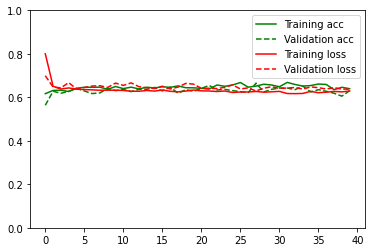

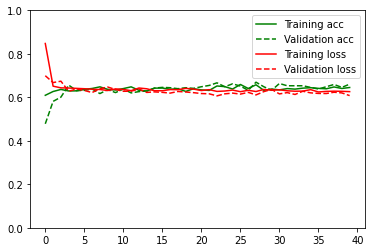

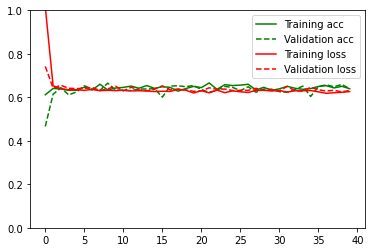

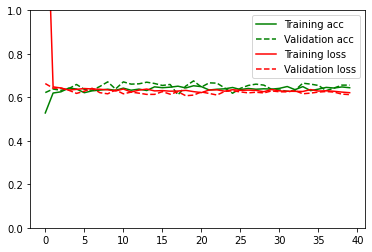


4-fold resnet validation accuracy
Mean: 0.6468609720468521	Std: 0.012114767319002195


In [ ]:
fit_results_list = process_manager.list()
validation_results_list = process_manager.list()

#execute each fold in a secondary process to avoid RAM saturation
for fold in range(K_FOLDS):
    p = multiprocessing.Process(target=resnet_fold_train, args=(fold, fit_results_list, validation_results_list))
    p.start()
    p.join()

for fit_results in fit_results_list:
  show_accuracy_loss_trends(fit_results)

validation_mean = np.mean(validation_results_list)
validation_std = np.std(validation_results_list)
print("\n" + str(K_FOLDS) + "-fold resnet validation accuracy\nMean: " + str(validation_mean) + "\tStd: " + str(validation_std))

###Evaluation

In [ ]:
def resnet_test(resnet_preds):
  if VERBOSE == 1: print("Testing")
  from keras.applications.resnet import preprocess_input as resnet_preprocess
  train_data, validation_data, train_labels, validation_labels = train_test_split(
                                                                                  train_data_no_baseline_RGB,
                                                                                  collapsed_train_labels,
                                                                                  train_size=0.8,
                                                                                  random_state=42,
                                                                                  shuffle=True
                                                                                )


  resnet_train_datagen = get_train_datagen(resnet_preprocess)
  resnet_validation_datagen = get_validation_datagen(resnet_preprocess)
  resnet_train_datagen.fit(train_data)
  resnet_validation_datagen.fit(validation_data)
  resnet_train_generator = resnet_train_datagen.flow(train_data, train_labels, batch_size=BATCH_SIZE)
  resnet_validation_generator = resnet_validation_datagen.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)


  model = get_resnet_model()
  fit_results = model.fit(
      resnet_train_generator,
      epochs=RESNET_TRAIN_EPOCHS,
      steps_per_epoch=int(np.ceil(resnet_train_generator.n / float(BATCH_SIZE))),
      validation_data=resnet_validation_generator,
      validation_steps=int(np.ceil(resnet_validation_generator.n / float(BATCH_SIZE))),
      verbose=VERBOSE
  )
  
  show_accuracy_loss_trends(fit_results.history)

  preds = model.predict(test_data_no_baseline_RGB)
  for pred in preds:
    resnet_preds.append(pred[0])
  
  model.save(os.path.join(MODELS_DIR,'pretrained_resnet.h5'))

Testing
Epoch 1/200
134/134 [==============================] - 18s 97ms/step - loss: 1.3432 - accuracy: 0.5972 - val_loss: 0.6624 - val_accuracy: 0.5989
Epoch 2/200
134/134 [==============================] - 12s 89ms/step - loss: 0.6418 - accuracy: 0.6190 - val_loss: 0.6416 - val_accuracy: 0.6138
Epoch 3/200
134/134 [==============================] - 12s 89ms/step - loss: 0.6507 - accuracy: 0.6225 - val_loss: 0.6471 - val_accuracy: 0.6250
Epoch 4/200
134/134 [==============================] - 12s 88ms/step - loss: 0.6409 - accuracy: 0.6262 - val_loss: 0.6449 - val_accuracy: 0.6325
Epoch 5/200
134/134 [==============================] - 12s 88ms/step - loss: 0.6241 - accuracy: 0.6517 - val_loss: 0.6722 - val_accuracy: 0.6175
Epoch 6/200
134/134 [==============================] - 12s 86ms/step - loss: 0.6312 - accuracy: 0.6340 - val_loss: 0.6457 - val_accuracy: 0.6567
Epoch 7/200
134/134 [==============================] - 12s 87ms/step - loss: 0.6374 - accuracy: 0.6375 - val_loss: 0.6420 

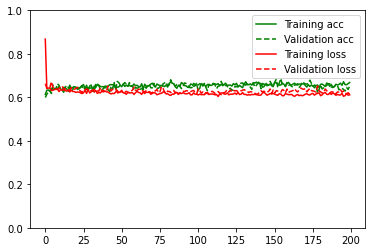

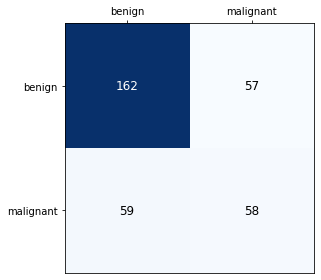


resnet test accuracy: 0.6547619047619048


In [ ]:
preds = process_manager.list()

#execute testing in a secondary process to avoid RAM saturation
p = multiprocessing.Process(target=resnet_test, args=(preds, ))
p.start()
p.join()

preds = np.asarray(preds)

show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
print("\nresnet test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

final_models_preds.update({"resnet": preds})

# VGG16

### Model architecture

In [ ]:
def get_vgg16_model():
  from tensorflow import keras
  from keras import layers
  from keras import models
  from keras.applications import VGG16
  vgg16_conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
  vgg16_conv_base.trainable = False

  vgg16_model = models.Sequential()
  vgg16_model.add(vgg16_conv_base)
  vgg16_model.add(layers.Flatten())
  vgg16_model.add(layers.Dense(256, activation = "sigmoid"))
  vgg16_model.add(layers.Dense(1, activation = "sigmoid"))

  # ada = keras.optimizers.Adam(learning_rate=0.0001)
  # sgd = keras.optimizers.SGD(learning_rate=0.1)
  rms = keras.optimizers.RMSprop(lr=2e-5)
  vgg16_model.compile(loss="binary_crossentropy", optimizer=rms, metrics=['accuracy'])
  return vgg16_model

### Training

In [ ]:
def vgg16_fold_train(fold, fit_results_list, validation_results_list):
  from keras.applications.vgg16 import preprocess_input as vgg16_preprocess
  if VERBOSE == 1: print("\nFold " + str(fold + 1) + " training")
  kfold_train_data = np.concatenate([kfold_data[:fold * num_val_samples],  kfold_data[(fold + 1) * num_val_samples:]], axis=0)
  kfold_validation_data = kfold_data[fold * num_val_samples: (fold + 1) * num_val_samples]

  kfold_train_labels = np.concatenate([kfold_labels[:fold * num_val_samples],  kfold_labels[(fold+ 1) * num_val_samples:]], axis=0)
  kfold_validation_labels = kfold_labels[fold * num_val_samples: (fold + 1) * num_val_samples]
  
  vgg16_train_datagen = get_train_datagen(vgg16_preprocess)
  vgg16_validation_datagen = get_validation_datagen(vgg16_preprocess)
  vgg16_train_datagen.fit(kfold_train_data)
  vgg16_validation_datagen.fit(kfold_validation_data)
  vgg16_train_generator = vgg16_train_datagen.flow(kfold_train_data, kfold_train_labels, batch_size=BATCH_SIZE)
  vgg16_validation_generator = vgg16_validation_datagen.flow(kfold_validation_data, kfold_validation_labels, batch_size=BATCH_SIZE)

  model = get_vgg16_model()
  fit_results = model.fit(
      vgg16_train_generator,
      epochs=VGG16_KFOLD_VALIDATION_EPOCHS,
      steps_per_epoch=int(np.ceil(vgg16_train_generator.n / float(BATCH_SIZE))),
      validation_data=vgg16_validation_generator,
      validation_steps=int(np.ceil(vgg16_validation_generator.n / float(BATCH_SIZE))),
      verbose=VERBOSE
  )

  validation_results = model.evaluate(vgg16_validation_generator, verbose=VERBOSE)

  
  fit_results_list.append(fit_results.history)
  validation_results_list.append(validation_results[1])


Fold 1 training
58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/40
126/126 [==============================] - 17s 105ms/step - loss: 0.8815 - accuracy: 0.5721 - val_loss: 0.8222 - val_accuracy: 0.5755
Epoch 2/40
126/126 [==============================] - 12s 94ms/step - loss: 0.7945 - accuracy: 0.5890 - val_loss: 0.7717 - val_accuracy: 0.5830
Epoch 3/40
126/126 [==============================] - 12s 95ms/step - loss: 0.7470 - accuracy: 0.5919 - val_loss: 0.7376 - val_accuracy: 0.5874
Epoch 4/40
126/126 [==============================] - 12s 94ms/step - loss: 0.7312 - accuracy: 0.5921 - val_loss: 0.7078 - val_accuracy: 0.5904
Epoch 5/40
126/126 [==============================] - 12s 94ms/step - loss: 0.7049 - accuracy: 0.6048 - val_loss: 0.6858 - val_accuracy: 0.6024
Epoch 6/40
126/126 [==============================] - 12s 94ms/step - loss: 0.6935 - accuracy: 0.5827 - val_loss: 0.6790 - val_accuracy: 0.5949
Epoch 7/40
126/126 [==============================] -

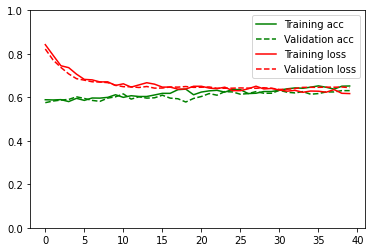

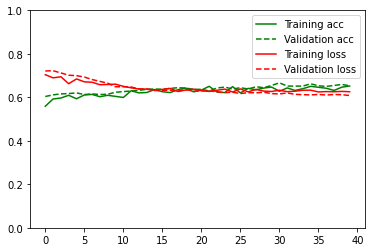

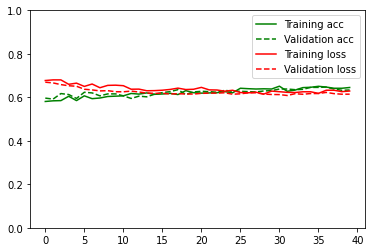

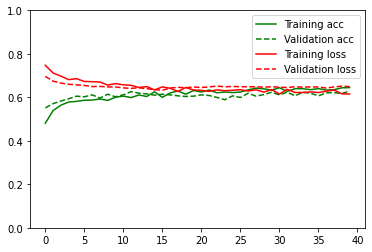


4-fold vgg16 validation accuracy
Mean: 0.6367712914943695	Std: 0.00962937254920835


In [ ]:
fit_results_list = process_manager.list()
validation_results_list = process_manager.list()

#execute each fold in a secondary process to avoid RAM saturation
for fold in range(K_FOLDS):
    p = multiprocessing.Process(target=vgg16_fold_train, args=(fold, fit_results_list, validation_results_list))
    p.start()
    p.join()

for fit_results in fit_results_list:
  show_accuracy_loss_trends(fit_results)

validation_mean = np.mean(validation_results_list)
validation_std = np.std(validation_results_list)
print("\n" + str(K_FOLDS) + "-fold vgg16 validation accuracy\nMean: " + str(validation_mean) + "\tStd: " + str(validation_std))

###Evaluation

In [ ]:
def vgg16_test(vgg16_preds):
  if VERBOSE == 1: print("Testing")
  from keras.applications.vgg16 import preprocess_input as vgg16_preprocess
  train_data, validation_data, train_labels, validation_labels = train_test_split(
                                                                                  train_data_no_baseline_RGB,
                                                                                  collapsed_train_labels,
                                                                                  train_size=0.8,
                                                                                  random_state=42,
                                                                                  shuffle=True
                                                                                )


  vgg16_train_datagen = get_train_datagen(vgg16_preprocess)
  vgg16_validation_datagen = get_validation_datagen(vgg16_preprocess)
  vgg16_train_datagen.fit(train_data)
  vgg16_validation_datagen.fit(validation_data)
  vgg16_train_generator = vgg16_train_datagen.flow(train_data, train_labels, batch_size=BATCH_SIZE)
  vgg16_validation_generator = vgg16_validation_datagen.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)


  model = get_vgg16_model()
  fit_results = model.fit(
      vgg16_train_generator,
      epochs=VGG16_TRAIN_EPOCHS,
      steps_per_epoch=int(np.ceil(vgg16_train_generator.n / float(BATCH_SIZE))),
      validation_data=vgg16_validation_generator,
      validation_steps=int(np.ceil(vgg16_validation_generator.n / float(BATCH_SIZE))),
      verbose=VERBOSE
  )
  
  show_accuracy_loss_trends(fit_results.history)

  preds = model.predict(test_data_no_baseline_RGB)
  for pred in preds:
    vgg16_preds.append(pred[0])
  
  model.save(os.path.join(MODELS_DIR,'pretrained_vgg16.h5'))

In [ ]:
preds = process_manager.list()

#execute testing in a secondary process to avoid RAM saturation
p = multiprocessing.Process(target=vgg16_test, args=(preds, ))
p.start()
p.join()

preds = np.asarray(preds)

show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
print("\nvgg16 test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

final_models_preds.update({"vgg16": preds})

#Comparisons

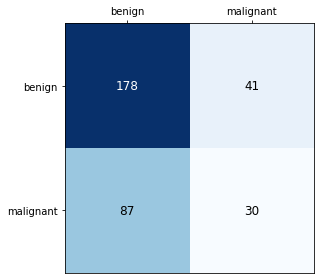


inception test accuracy: 0.6190476190476191


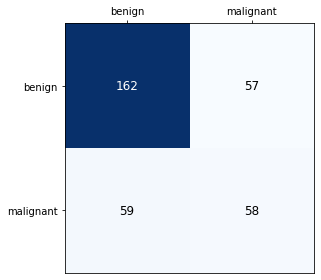


resnet test accuracy: 0.6547619047619048


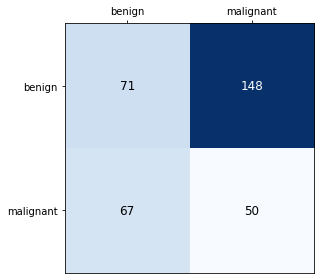


vgg16 test accuracy: 0.3601190476190476


In [ ]:
def load_models(preds, model_name):
  from keras.models import load_model

  current_model = load_model(os.path.join(MODELS_DIR,'pretrained_'+model_name+'.h5'))
  model_preds = current_model.predict(test_data_no_baseline_RGB)
  for pred in model_preds:
    preds.append(pred[0])


#execute fine tuning in a secondary process to avoid RAM saturation
models = ["inception", "resnet", "vgg16"]
for model in models:
  preds = process_manager.list()
  p = multiprocessing.Process(target=load_models, args=(preds, model))
  p.start()
  p.join()

  preds = np.asarray(preds)

  show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
  print("\n" + model + " test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

  final_models_preds.update({model: preds})

    

In [ ]:
show_roc_curves(final_models_preds)

#Fine Tuning

##Inception

In [ ]:
def inception_fine_tuning(inception_preds):
  if VERBOSE == 1: print("Testing")
  import keras
  from keras.models import load_model
  from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess
  train_data, validation_data, train_labels, validation_labels = train_test_split(
                                                                                  train_data_no_baseline_RGB,
                                                                                  collapsed_train_labels,
                                                                                  train_size=0.8,
                                                                                  random_state=42,
                                                                                  shuffle=True
                                                                                )


  inception_train_datagen = get_train_datagen(inception_v3_preprocess)
  inception_validation_datagen = get_validation_datagen(inception_v3_preprocess)
  inception_train_datagen.fit(train_data)
  inception_validation_datagen.fit(validation_data)
  inception_train_generator = inception_train_datagen.flow(train_data, train_labels, batch_size=BATCH_SIZE)
  inception_validation_generator = inception_validation_datagen.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)

  final_model = load_model(os.path.join(MODELS_DIR,'pretrained_inception.h5'))

  convolutional_layer = final_model.get_layer("inception_v3")
  for layer in convolutional_layer.layers[:-4]:
    layer.trainable = False
  for layer in convolutional_layer.layers[-4:]:
    layer.trainable = True
  
  rms = keras.optimizers.RMSprop(lr=2e-6)
  final_model.compile(loss="binary_crossentropy", optimizer=rms, metrics=['accuracy'])

  fit_results = final_model.fit(
      inception_train_generator,
      epochs=INCEPTION_TRAIN_EPOCHS,
      steps_per_epoch=int(np.ceil(inception_train_generator.n / float(BATCH_SIZE))),
      validation_data=inception_validation_generator,
      validation_steps=int(np.ceil(inception_validation_generator.n / float(BATCH_SIZE))),
      verbose=VERBOSE
  )

  show_accuracy_loss_trends(fit_results.history)

  preds = final_model.predict(test_data_no_baseline_RGB)
  for pred in preds:
    inception_preds.append(pred[0])
  
  final_model.save(os.path.join(MODELS_DIR,'pretrained_inception_tuned.h5'))

Testing
Epoch 1/50
134/134 [==============================] - 21s 106ms/step - loss: 0.6677 - accuracy: 0.5808 - val_loss: 0.6427 - val_accuracy: 0.6231
Epoch 2/50
134/134 [==============================] - 12s 91ms/step - loss: 0.6399 - accuracy: 0.6320 - val_loss: 0.6422 - val_accuracy: 0.6381
Epoch 3/50
134/134 [==============================] - 12s 90ms/step - loss: 0.6376 - accuracy: 0.6179 - val_loss: 0.6456 - val_accuracy: 0.6045
Epoch 4/50
134/134 [==============================] - 12s 92ms/step - loss: 0.6426 - accuracy: 0.6246 - val_loss: 0.6423 - val_accuracy: 0.6231
Epoch 5/50
134/134 [==============================] - 12s 91ms/step - loss: 0.6337 - accuracy: 0.6215 - val_loss: 0.6524 - val_accuracy: 0.6213
Epoch 6/50
134/134 [==============================] - 12s 91ms/step - loss: 0.6401 - accuracy: 0.6089 - val_loss: 0.6506 - val_accuracy: 0.6138
Epoch 7/50
134/134 [==============================] - 12s 91ms/step - loss: 0.6368 - accuracy: 0.6318 - val_loss: 0.6441 - val_

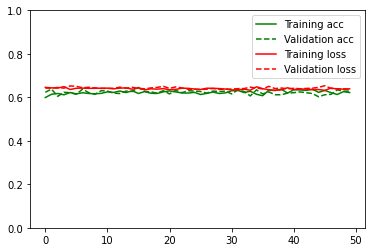

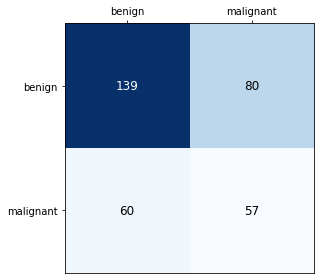


Tuned inception test accuracy: 0.5833333333333334


In [ ]:
preds = process_manager.list()

#execute fine tuning in a secondary process to avoid RAM saturation
p = multiprocessing.Process(target=inception_fine_tuning, args=(preds, ))
p.start()
p.join()

preds = np.asarray(preds)

show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
print("\nTuned inception test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

fine_tuned_models_preds.update({"inception_tuned": preds})

##ResNet50

In [ ]:
def resnet_fine_tuning(resnet_preds):
  if VERBOSE == 1: print("Testing")
  import keras
  from keras.models import load_model
  from keras.applications.resnet import preprocess_input as resnet_preprocess
  train_data, validation_data, train_labels, validation_labels = train_test_split(
                                                                                  train_data_no_baseline_RGB,
                                                                                  collapsed_train_labels,
                                                                                  train_size=0.8,
                                                                                  random_state=42,
                                                                                  shuffle=True
                                                                                )


  resnet_train_datagen = get_train_datagen(resnet_preprocess)
  resnet_validation_datagen = get_validation_datagen(resnet_preprocess)
  resnet_train_datagen.fit(train_data)
  resnet_validation_datagen.fit(validation_data)
  resnet_train_generator = resnet_train_datagen.flow(train_data, train_labels, batch_size=BATCH_SIZE)
  resnet_validation_generator = resnet_validation_datagen.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)

  final_model = load_model(os.path.join(MODELS_DIR,'pretrained_resnet.h5'))

  convolutional_layer = final_model.get_layer("resnet50") 
  
  for layer in convolutional_layer.layers:
    layer.trainable = False

  for layer in convolutional_layer.layers:
      if layer.name == "conv5_block3_3_conv":
        layer.trainable = True
  
  ada = keras.optimizers.Adam(learning_rate=0.0001)
  final_model.compile(loss="binary_crossentropy", optimizer=ada, metrics=['accuracy'])

  fit_results = final_model.fit(
      resnet_train_generator,
      epochs=RESNET_TRAIN_EPOCHS,
      steps_per_epoch=int(np.ceil(resnet_train_generator.n / float(BATCH_SIZE))),
      validation_data=resnet_validation_generator,
      validation_steps=int(np.ceil(resnet_validation_generator.n / float(BATCH_SIZE))),
      verbose=VERBOSE
  )

  show_accuracy_loss_trends(fit_results.history)

  preds = final_model.predict(test_data_no_baseline_RGB)
  for pred in preds:
    resnet_preds.append(pred[0])
  
  final_model.save(os.path.join(MODELS_DIR,'pretrained_resnet_tuned.h5'))


Testing
Epoch 1/200
134/134 [==============================] - 18s 96ms/step - loss: 0.8676 - accuracy: 0.5154 - val_loss: 0.7254 - val_accuracy: 0.5728
Epoch 2/200
134/134 [==============================] - 11s 85ms/step - loss: 0.6994 - accuracy: 0.6043 - val_loss: 0.7208 - val_accuracy: 0.5877
Epoch 3/200
134/134 [==============================] - 12s 87ms/step - loss: 0.7076 - accuracy: 0.5787 - val_loss: 0.6960 - val_accuracy: 0.5858
Epoch 4/200
134/134 [==============================] - 12s 89ms/step - loss: 0.6906 - accuracy: 0.5936 - val_loss: 0.6890 - val_accuracy: 0.5821
Epoch 5/200
134/134 [==============================] - 11s 85ms/step - loss: 0.6849 - accuracy: 0.5973 - val_loss: 0.6739 - val_accuracy: 0.6045
Epoch 6/200
134/134 [==============================] - 11s 84ms/step - loss: 0.6683 - accuracy: 0.6220 - val_loss: 0.6873 - val_accuracy: 0.6250
Epoch 7/200
134/134 [==============================] - 12s 87ms/step - loss: 0.6409 - accuracy: 0.6522 - val_loss: 0.6750 

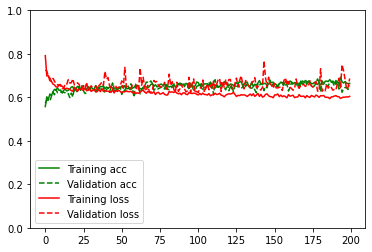

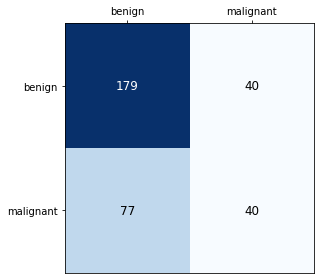


Tuned resnet test accuracy: 0.6517857142857143


In [ ]:
preds = process_manager.list()

#execute fine tuning in a secondary process to avoid RAM saturation
p = multiprocessing.Process(target=resnet_fine_tuning, args=(preds, ))
p.start()
p.join()

preds = np.asarray(preds)

show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
print("\nTuned resnet test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

fine_tuned_models_preds.update({"resnet_tuned": preds})

##VGG16

In [ ]:
def vgg16_fine_tuning(vgg16_preds):
  if VERBOSE == 1: print("Testing")
  import keras
  from keras.models import load_model
  from keras.applications.vgg16 import preprocess_input as vgg16_preprocess
  train_data, validation_data, train_labels, validation_labels = train_test_split(
                                                                                  train_data_no_baseline_RGB,
                                                                                  collapsed_train_labels,
                                                                                  train_size=0.8,
                                                                                  random_state=42,
                                                                                  shuffle=True
                                                                                )


  vgg16_train_datagen = get_train_datagen(vgg16_preprocess)
  vgg16_validation_datagen = get_validation_datagen(vgg16_preprocess)
  vgg16_train_datagen.fit(train_data)
  vgg16_validation_datagen.fit(validation_data)
  vgg16_train_generator = vgg16_train_datagen.flow(train_data, train_labels, batch_size=BATCH_SIZE)
  vgg16_validation_generator = vgg16_validation_datagen.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)

  final_model = load_model(os.path.join(MODELS_DIR,'pretrained_vgg16.h5'))
  convolutional_layer = final_model.get_layer("vgg16") 
  for layer in convolutional_layer.layers:
    layer.trainable = False

  for layer in convolutional_layer.layers[-4:]:
    layer.trainable = True
  
  
  rms = keras.optimizers.RMSprop(lr=2e-6)
  final_model.compile(loss="binary_crossentropy", optimizer=rms, metrics=['accuracy'])

  fit_results = final_model.fit(
      vgg16_train_generator,
      epochs=VGG16_TRAIN_EPOCHS,
      steps_per_epoch=int(np.ceil(vgg16_train_generator.n / float(BATCH_SIZE))),
      validation_data=vgg16_validation_generator,
      validation_steps=int(np.ceil(vgg16_validation_generator.n / float(BATCH_SIZE))),
      verbose=VERBOSE
  )

  show_accuracy_loss_trends(fit_results.history)

  preds = final_model.predict(test_data_no_baseline_RGB)
  for pred in preds:
    vgg16_preds.append(pred[0])
  
  final_model.save(os.path.join(MODELS_DIR,'pretrained_vgg16_tuned.h5'))

Testing
Epoch 1/50
134/134 [==============================] - 16s 98ms/step - loss: 1.3409 - accuracy: 0.3454 - val_loss: 1.2464 - val_accuracy: 0.3545
Epoch 2/50
134/134 [==============================] - 12s 89ms/step - loss: 1.2672 - accuracy: 0.3487 - val_loss: 1.1600 - val_accuracy: 0.3955
Epoch 3/50
134/134 [==============================] - 12s 87ms/step - loss: 1.1752 - accuracy: 0.3702 - val_loss: 1.1122 - val_accuracy: 0.3825
Epoch 4/50
134/134 [==============================] - 12s 88ms/step - loss: 1.0891 - accuracy: 0.3981 - val_loss: 1.0402 - val_accuracy: 0.4160
Epoch 5/50
134/134 [==============================] - 12s 87ms/step - loss: 1.1146 - accuracy: 0.3699 - val_loss: 1.0079 - val_accuracy: 0.3955
Epoch 6/50
134/134 [==============================] - 12s 89ms/step - loss: 1.0255 - accuracy: 0.4077 - val_loss: 0.9635 - val_accuracy: 0.4142
Epoch 7/50
134/134 [==============================] - 12s 89ms/step - loss: 1.0073 - accuracy: 0.3942 - val_loss: 0.9302 - val_a

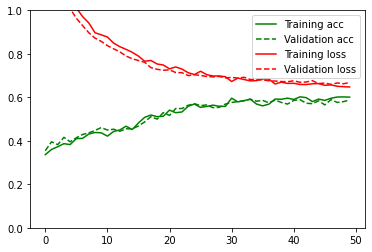

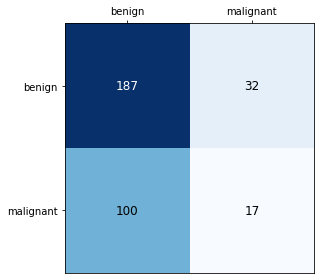


Tuned VGG16 test accuracy: 0.6071428571428571


In [ ]:
preds = process_manager.list()

#execute fine tuning in a secondary process to avoid RAM saturation
p = multiprocessing.Process(target=vgg16_fine_tuning, args=(preds, ))
p.start()
p.join()

preds = np.asarray(preds)

show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
print("\nTuned VGG16 test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

fine_tuned_models_preds.update({"vgg16_tuned": preds})

##Comparisons

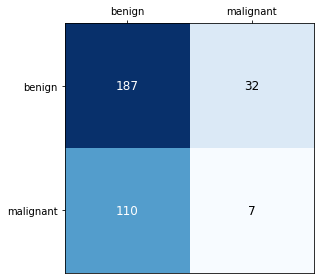


inception_tuned test accuracy: 0.5773809523809523


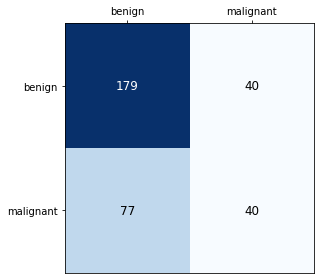


resnet_tuned test accuracy: 0.6517857142857143


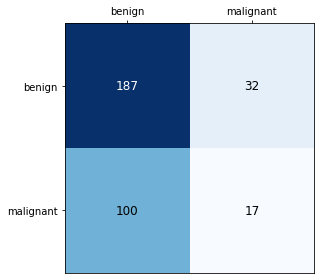


vgg16_tuned test accuracy: 0.6071428571428571


In [ ]:
def load_fine_tuned_models(preds, model_name):
  from keras.models import load_model

  current_model = load_model(os.path.join(MODELS_DIR,'pretrained_'+model_name+'.h5'))
  model_preds = current_model.predict(test_data_no_baseline_RGB)
  for pred in model_preds:
    preds.append(pred[0])


#execute fine tuning in a secondary process to avoid RAM saturation
models = ["inception_tuned", "resnet_tuned", "vgg16_tuned"]
for model in models:
  preds = process_manager.list()
  p = multiprocessing.Process(target=load_fine_tuned_models, args=(preds, model))
  p.start()
  p.join()

  preds = np.asarray(preds)

  show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
  print("\n" + model + " test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

  fine_tuned_models_preds.update({model: preds})

    

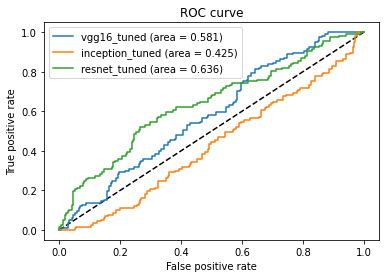

In [ ]:
show_roc_curves(fine_tuned_models_preds)